In [426]:
import tensorflow as tf
import numpy as np

model_file = 'face_detection_front.tflite'
interpreter = tf.lite.Interpreter(
    model_path=model_file)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# print(f'input_details {input_details}')
print(f'output_details {output_details}')

output_details [{'name': 'regressors', 'index': 175, 'shape': array([  1, 896,  16]), 'shape_signature': array([  1, 896,  16]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'classificators', 'index': 174, 'shape': array([  1, 896,   1]), 'shape_signature': array([  1, 896,   1]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


(1, 128, 128, 3)

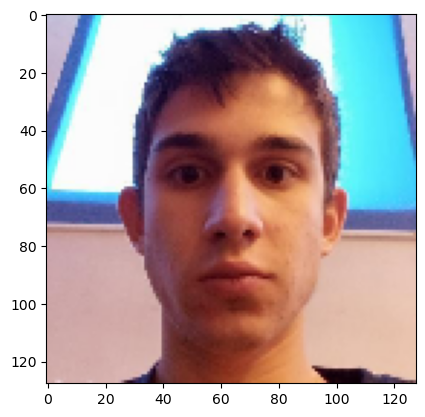

In [487]:
import cv2
import matplotlib.pyplot as plt

image = cv2.imread('metest.jpg')
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# plt.imshow(image)

# plt.imshow(image[:,:,::-1])

image_cropped = image[:image.shape[0], :image.shape[0], ::-1] # crop to avoid letterboxing step
# plt.imshow(image_cropped)

img = cv2.resize(image_cropped, ( dim,  dim))[np.newaxis, :, :, :]

plt.imshow(img[0])

img = (np.float32(img) - 0.0) / 255.0  # normalization (specified in tflite_converter_calculator, not in model card)
img_input = (img - 0.5) / 0.5
#img = (np.float32(img) - 0.0) / 255.0 # normalization (specified in tflite_converter_calculator, not in model card)
img_input.shape

Maybe this is better input parser

In [488]:
dim =  128
img = cv2.imread('metest.jpg')

img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img_height, img_width, img_channels = img.shape


		# Input values should be from -1 to 1 with a size of  dim x  dim pixels for the fornt model
		# and 256 x 256 pixels for the back model

img = img / 255.0

img_resized = tf.image.resize(img, [  dim,  dim], 
									method='bicubic', preserve_aspect_ratio=False)



img_input = img_resized.numpy()
img_input = (img_input - 0.5) / 0.5

		# Adjust matrix dimenstions
reshape_img = img_input.reshape(1,  dim,  dim, img_channels)
tensor = tf.convert_to_tensor(reshape_img, dtype=tf.float32)



In [489]:
interpreter.set_tensor(input_details[0]['index'], tensor)

interpreter.invoke()

output0 =  np.squeeze(interpreter.get_tensor(output_details[0]['index']))
output1 =  np.squeeze(interpreter.get_tensor(output_details[1]['index']))

output0[0]

array([-0.8067198 , -0.23657401, 27.07461   , 27.074299  , -0.92773604,
       -3.1701436 ,  2.3478687 , -3.1629493 ,  1.1909349 ,  0.9673949 ,
       -0.59023213,  4.7349505 , -8.350578  , -2.610541  ,  3.574352  ,
       -2.1376793 ], dtype=float32)

In [490]:
scoreThreshold = 0.7
iouThreshold = 0.3
sigmoidScoreThreshold = np.log(scoreThreshold/(1-scoreThreshold))

def filterDetections(output1):

		# Filter based on the score threshold before applying sigmoid function
		goodDetections = np.where(output1 > sigmoidScoreThreshold)[0]
		

		# Convert scores back from sigmoid values
		scores = 1.0 /(1.0 + np.exp(-output1[goodDetections]))

		return scores, goodDetections

scores, goodDetectionsIndices  = filterDetections(output1)



In [491]:
ssd_anchors_calculator_options = SsdAnchorsCalculatorOptions(input_size_width=128, input_size_height=128, min_scale=0.1484375, max_scale=0.75
					, anchor_offset_x=0.5, anchor_offset_y=0.5, num_layers=4
					, feature_map_width=[], feature_map_height=[]
					, strides=[8, 16, 16, 16], aspect_ratios=[1.0]
					, reduce_boxes_in_lowest_layer=False, interpolated_scale_aspect_ratio=1.0
					, fixed_anchor_size=True)
anchors = gen_anchors(ssd_anchors_calculator_options)


In [492]:
KEY_POINT_SIZE = 6
def extractDetections( output0, goodDetectionsIndices):

		numGoodDetections = goodDetectionsIndices.shape[0]
	

		keypoints = np.zeros((numGoodDetections, KEY_POINT_SIZE, 2))
		boxes = np.zeros((numGoodDetections, 4))
		
		for idx, detectionIdx in enumerate(goodDetectionsIndices):
			anchor =  anchors[detectionIdx]
			
			sx = output0[detectionIdx, 0]
			sy = output0[detectionIdx, 1]
			w = output0[detectionIdx, 2]
			h = output0[detectionIdx, 3]


			cx = sx + anchor.x_center *   dim
			cy = sy + anchor.y_center *   dim

			cx /=   dim
			cy /=   dim
			w /=   dim
			h /=   dim

			for j in range(KEY_POINT_SIZE):
				lx = output0[detectionIdx, 4 + (2 * j) + 0]
				ly = output0[detectionIdx, 4 + (2 * j) + 1]
				lx += anchor.x_center *   dim
				ly += anchor.y_center *   dim
				lx /=   dim
				ly /=   dim
				keypoints[idx,j,:] = np.array([lx, ly])

			boxes[idx,:] = np.array([cx - w * 0.5, cy - h * 0.5, cx + w * 0.5, cy + h * 0.5])

		return boxes, keypoints
boxes, keypoints = extractDetections(output0, goodDetectionsIndices)
print(goodDetectionsIndices)

[723 724 725 729 730 731 771 772 773 777 778 779]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(12, 6, 2)


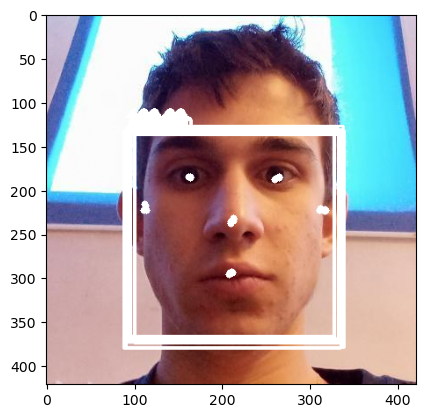

In [493]:
for boundingBox in boxes:
    x1 = (img_width * boundingBox[0]).astype(int)
    x2 = (img_width * boundingBox[2]).astype(int)
    y1 = (img_height * boundingBox[1]).astype(int)
    y2 = (img_height * boundingBox[3]).astype(int)

    cv2.rectangle(img, (x1, y1), (x2, y2), (22, 22, 250), 2)
    cv2.putText(img, '{:.2f}'.format(100), (x1, y1 - 6)
								, cv2.FONT_HERSHEY_SIMPLEX, 0.6, (22, 22, 250), 2)
                            
print(keypoints.shape)
for i in range(0,5):
    for j in range(0,6):
        xKeypoint = (keypoints[i,j,0] * img_width).astype(int)
        yKeypoint = (keypoints[i,j,1] * img_height).astype(int)
        cv2.circle(img,(xKeypoint,yKeypoint), 4, (214, 202, 18), -1)

plt.imshow(img)              
        

In [459]:
class Results:
	def __init__(self, boxes, keypoints, scores):
		boxes = boxes
		keypoints = keypoints
		scores = scores
def filterWithNonMaxSupression( boxes, keypoints, scores):
		# Filter based on non max suppression
		selected_indices = tf.image.non_max_suppression(boxes, scores, 1, iouThreshold)
		filtered_boxes = tf.gather(boxes, selected_indices).numpy()
		filtered_keypoints = tf.gather(keypoints, selected_indices).numpy()
		filtered_scores = tf.gather(scores, selected_indices).numpy()

		detectionResults = Results(filtered_boxes, filtered_keypoints, filtered_scores)
		return detectionResults

detectionResults = filterWithNonMaxSupression(boxes[:,:,0], [], scores)

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed